BEER CLASSIFICATION PROJECT

# Notebook 4 - Final Model Deep-Dive

This notebook will be used to take a look at the outputs of the classification model, tune as-needed, and finalize findings.

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,  StratifiedKFold, cross_validate, train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, top_k_accuracy_score, f1_score, log_loss, precision_score, recall_score, roc_auc_score
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import rgb2hex
import seaborn as sns
import textwrap
import pickle
sns.set_theme(style="white", palette="colorblind")
%matplotlib inline

In [4]:
sns.set_style("white")
sns.set_context("talk")
sns.set_palette("Blues")
main_cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
main_color = main_cmap(0.75)
main_color = rgb2hex(main_color)

## Import and Prep Data

In [5]:
df = pd.read_parquet('./data/processed/df_processed')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3170 entries, 0 to 3196
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   abv          3170 non-null   float64 
 1   min_ibu      3170 non-null   int64   
 2   max_ibu      3170 non-null   int64   
 3   astringency  3170 non-null   int64   
 4   body         3170 non-null   int64   
 5   alcohol      3170 non-null   int64   
 6   bitter       3170 non-null   int64   
 7   sweet        3170 non-null   int64   
 8   sour         3170 non-null   int64   
 9   salty        3170 non-null   int64   
 10  fruits       3170 non-null   int64   
 11  hoppy        3170 non-null   int64   
 12  spices       3170 non-null   int64   
 13  malty        3170 non-null   int64   
 14  style_l1     3170 non-null   category
dtypes: category(1), float64(1), int64(13)
memory usage: 375.9 KB
None


,abv,min_ibu,max_ibu,astringency,body,alcohol,bitter,sweet,sour,salty,fruits,hoppy,spices,malty,style_l1
0,5.3,25,50,13,32,9,47,74,33,0,33,57,8,111,Altbier
1,7.2,25,50,12,57,18,33,55,16,0,24,35,12,84,Altbier
2,5.0,25,50,14,37,6,42,43,11,0,10,54,4,62,Altbier
3,8.5,25,50,13,55,31,47,101,18,1,49,40,16,119,Altbier
4,7.2,25,50,25,51,26,44,45,9,1,11,51,20,95,Altbier


In [6]:
# Create X, y
X = df.drop(columns='style_l1')
y = df['style_l1'].astype('category')

# Set random state
r = 0

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=r, stratify=y)

# Set metrics for scoring
cv_scoring_metric = 'balanced_accuracy'

# Create the inner loop cv
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=r)

## Final Model Retrain

Now, we'll re-fit the HGBT model on the full `train` set using cross-validation to select the best hyperparameters. Finally, we'll use the held-out `test` set to test performance and look at results.

In [5]:
# Create the estimator object
hgbt_estimator = HistGradientBoostingClassifier()

# Create the Pipeline object
hgbt_pipe = Pipeline(steps=[('estimator', hgbt_estimator)])

# Create the parameter grid for searching
hgbt_param_grid = [
    {
        "estimator__max_iter": [250, 500],
        "estimator__max_depth": [4, 8],
        "estimator__learning_rate": [0.01, 0.04],
    }
]

model = GridSearchCV(hgbt_pipe, hgbt_param_grid, cv=inner_cv, scoring=cv_scoring_metric, refit=True)
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('estimator',
                                        HistGradientBoostingClassifier())]),
             param_grid=[{'estimator__learning_rate': [0.01, 0.04],
                          'estimator__max_depth': [4, 8],
                          'estimator__max_iter': [250, 500]}],
             scoring='balanced_accuracy')

In [6]:
with open('data/model_pkl', 'wb') as files:
    pickle.dump(model, files)

In [7]:
with open('data/model_pkl', 'rb') as handle:
    model = pickle.load(handle)

In [8]:
hgbt = model.best_estimator_
y_preds = hgbt.predict(X_test)

In [9]:
model.best_params_

{'estimator__learning_rate': 0.04,
 'estimator__max_depth': 8,
 'estimator__max_iter': 500}

In [10]:
pred_df = (
    pd.DataFrame([y_preds, y_test])
    .transpose()
    .rename(columns={0:'predictions', 1:'actuals'})
)

## Output Review & Deep-Dive

In [11]:
scoring_metrics = {
    'Accuracy': [accuracy_score, {}],
    'Balanced Accuracy': [balanced_accuracy_score, {}],
    'Precision (Micro)': [precision_score, {'average': 'micro'}],
    'Precision (Macro)': [precision_score, {'average': 'macro'}],
    'Precision (Weighted)': [precision_score, {'average': 'weighted'}],
    'Recall (Micro)': [recall_score, {'average': 'micro'}],
    'Recall (Macro)': [recall_score, {'average': 'macro'}],
    'Recall (Weighted)': [recall_score, {'average': 'weighted'}],
    'F1 (Micro)': [f1_score, {'average': 'micro'}],
    'F1 (Macro)': [f1_score, {'average': 'macro'}],
    'F1 (Weighted)': [f1_score, {'average': 'weighted'}]
    }


perf_metrics = {}
for k, v in scoring_metrics.items():
    perf_metrics[k] = v[0](y_test, y_preds, **v[1])

perf_metrics = pd.Series(perf_metrics)


In [12]:
perf_metrics

Accuracy                0.861286
Balanced Accuracy       0.861348
Precision (Micro)       0.861286
Precision (Macro)       0.869391
Precision (Weighted)    0.864044
Recall (Micro)          0.861286
Recall (Macro)          0.861348
Recall (Weighted)       0.861286
F1 (Micro)              0.861286
F1 (Macro)              0.860936
F1 (Weighted)           0.859950
dtype: float64

In [13]:
# Feature importance
imp = permutation_importance(hgbt, X_test, y_test, n_repeats=5, random_state=r)

In [14]:
print('Baseline score (accuracy) is {:.4f}'.format(hgbt.score(X_test, y_test)))

Baseline score (accuracy) is 0.8613


In [15]:
feat_imps = {}
for i in imp.importances_mean.argsort()[::-1]:
    print(f"{hgbt.feature_names_in_[i]:<14}"
          f"{imp.importances_mean[i]:.4f}"
          f" +/- {imp.importances_std[i]:.4f}"
    )
    feat_imps[hgbt.feature_names_in_[i]] = imp.importances_mean[i]

feat_imps_df = pd.DataFrame(feat_imps.items(), columns=['feature', 'permutation_importance'])


min_ibu       0.4482 +/- 0.0137
max_ibu       0.4166 +/- 0.0159
abv           0.0694 +/- 0.0031
hoppy         0.0595 +/- 0.0040
body          0.0525 +/- 0.0074
spices        0.0444 +/- 0.0057
sour          0.0363 +/- 0.0083
malty         0.0219 +/- 0.0054
fruits        0.0197 +/- 0.0034
astringency   0.0136 +/- 0.0029
bitter        0.0121 +/- 0.0015
alcohol       0.0108 +/- 0.0032
sweet         0.0078 +/- 0.0054
salty         -0.0010 +/- 0.0019


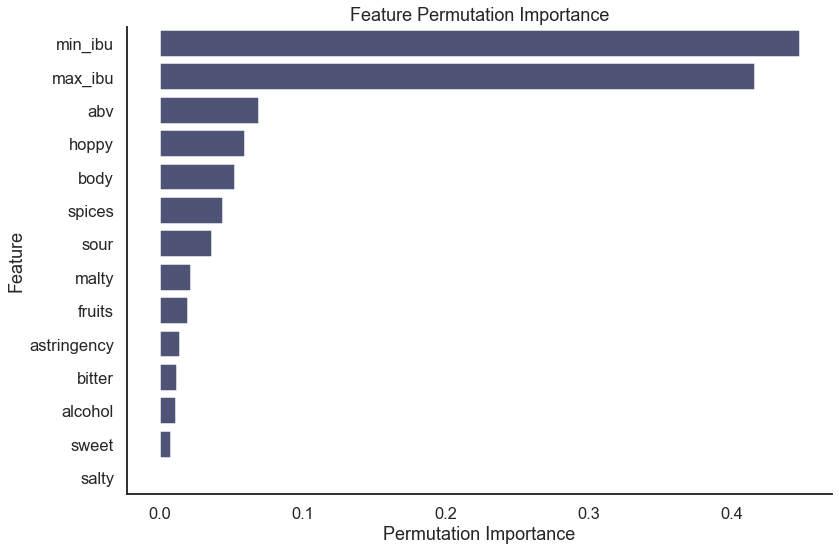

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=feat_imps_df, y='feature', x ='permutation_importance', color=main_color)
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Feature Permutation Importance')
sns.despine()
plt.tight_layout()
plt.savefig('figures/feature_importance.png')

Index(['Lager', 'Stout', 'Wheat Beer', 'Porter', 'IPA', 'Strong Ale', 'Bock',
       'Pale Ale', 'Pilsner', 'Red Ale', 'Lambic', 'Bitter', 'Brown Ale',
       'Barleywine', 'Blonde Ale', 'Sour', 'Farmhouse Ale', 'Altbier',
       'Winter Warmer', 'Quadrupel (Quad)', 'Dubbel', 'Fruit and Field Beer',
       'Rye Beer', 'Tripel', 'Scottish Ale', 'Scotch Ale / Wee Heavy',
       'Low Alcohol Beer', 'Happoshu', 'Mild Ale', 'Pumpkin Beer',
       'Smoked Beer', 'Old Ale', 'Herb and Spice Beer', 'Cream Ale',
       'Chile Beer', 'Wild Ale', 'Kölsch', 'Kvass',
       'California Common / Steam Beer', 'Gruit / Ancient Herbed Ale'],
      dtype='object', name='value')

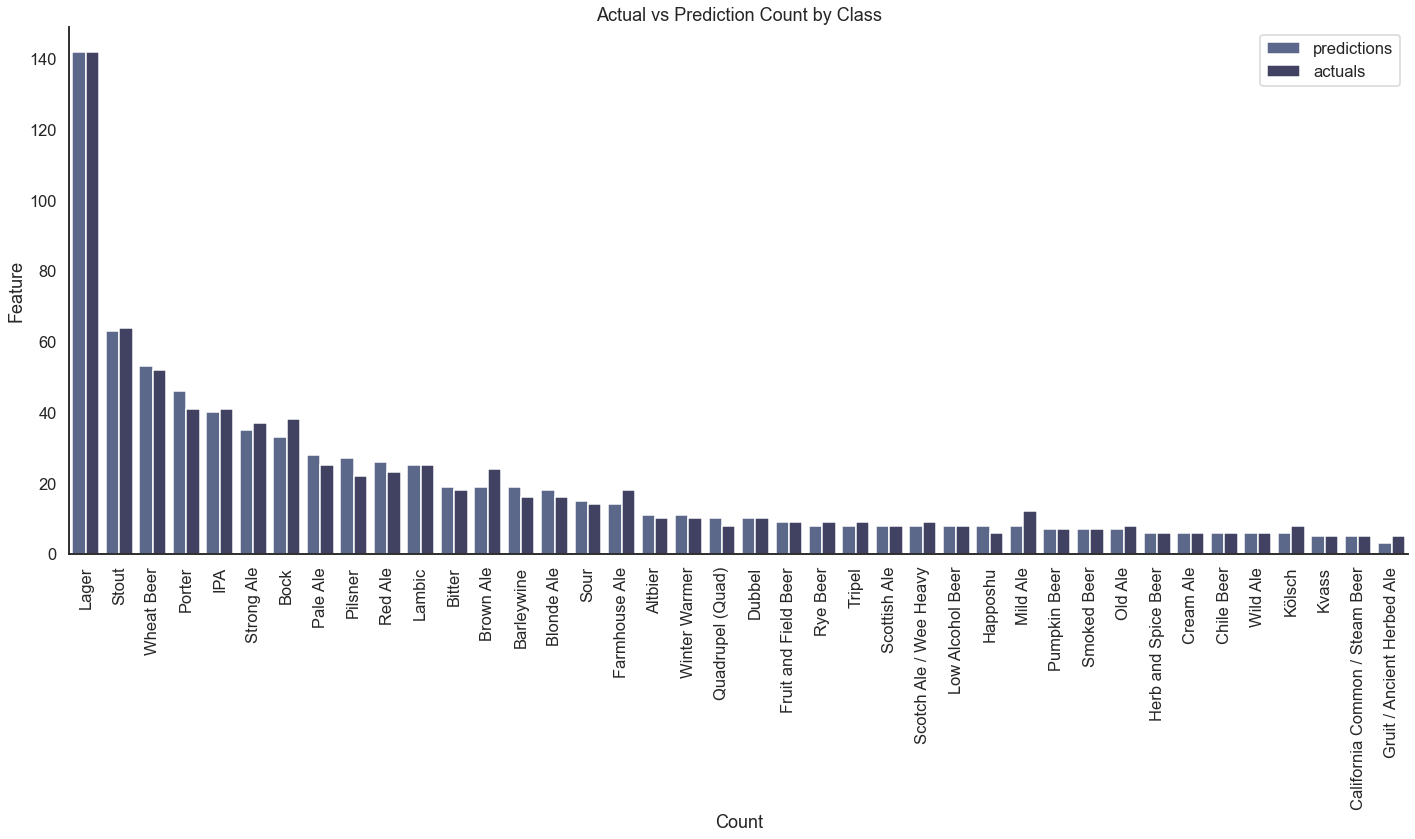

In [32]:
fig, ax = plt.subplots(figsize=(20, 12))
pred_df_melt = pred_df[['predictions', 'actuals']].melt()
order =(
    pred_df_melt
    .query('variable=="predictions"')
    .groupby('value')
    .count()
    .sort_values('variable', ascending=False)
    .index
)
sns.countplot(data=pred_df_melt, x='value', hue='variable', palette=[main_cmap(0.65), main_cmap(0.85)], order=order)
ax.set_xlabel('Count')
ax.set_ylabel('Feature')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:])
plt.title('Actual vs Prediction Count by Class')
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()
plt.savefig('figures/prediction_counts.png')

In [33]:
# For each category, see the next most similarly categorized beers and their spider plots (?) Cluster(?) Smart confusion matrix
pred_df['match'] = pred_df['predictions'] == pred_df['actuals']
miss_summ_df = (
    pred_df.groupby('actuals', as_index=False)
    .agg({'predictions':'count', 'match':'sum'})
)
miss_summ_df = (
    miss_summ_df.assign(misses=miss_summ_df.predictions - miss_summ_df.match)
    .sort_values('misses', ascending=False)
)

miss_summ_df.head()


,actuals,predictions,match,misses
18,Lager,142,125,17
25,Porter,41,30,11
35,Strong Ale,37,27,10
34,Stout,64,55,9
5,Brown Ale,24,16,8


In [34]:
miss_detail_df = (
    pred_df.query('match==False')
    .groupby(['actuals', 'predictions'], as_index=False)
    .agg({'match':'count'})
    .sort_values('match', ascending=False)
)

miss_detail_df.head()

,actuals,predictions,match
41,Porter,Stout,7
53,Stout,Porter,6
58,Tripel,Strong Ale,5
57,Strong Ale,Tripel,4
22,Kölsch,Lager,4


In [35]:
spider_cols = ['astringency', 'body', 'alcohol', 'bitter', 'sweet', 'sour', 'salty', 'fruits', 'hoppy', 'spices', 'malty']
df_agg = df[['style_l1'] + spider_cols].groupby('style_l1', as_index=False).mean()
df_agg.iloc[:, 1:] = df_agg.iloc[:, 1:] / (df_agg.iloc[:, 1:].max(axis=0) * 1.05)
print(df_agg.info())

df_agg.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   style_l1     40 non-null     category
 1   astringency  40 non-null     float64 
 2   body         40 non-null     float64 
 3   alcohol      40 non-null     float64 
 4   bitter       40 non-null     float64 
 5   sweet        40 non-null     float64 
 6   sour         40 non-null     float64 
 7   salty        40 non-null     float64 
 8   fruits       40 non-null     float64 
 9   hoppy        40 non-null     float64 
 10  spices       40 non-null     float64 
 11  malty        40 non-null     float64 
dtypes: category(1), float64(11)
memory usage: 5.0 KB
None


,style_l1,astringency,body,alcohol,bitter,sweet,sour,salty,fruits,hoppy,spices,malty
0,Altbier,0.526897,0.472369,0.202220,0.650561,0.514395,0.146564,0.192047,0.262008,0.616501,0.091376,0.865675
1,Barleywine,0.295879,0.603946,0.851150,0.659201,0.898091,0.239797,0.139679,0.630080,0.537708,0.174633,0.864047
2,Bitter,0.449575,0.529392,0.170567,0.863720,0.452232,0.208627,0.179573,0.332119,0.869169,0.106157,0.719168
3,Blonde Ale,0.548677,0.344669,0.200145,0.433023,0.374068,0.282211,0.460563,0.456502,0.508786,0.154302,0.439643
4,Bock,0.348518,0.557577,0.422946,0.416704,0.676283,0.168501,0.123172,0.418950,0.334719,0.158283,0.801906


In [133]:
def make_spider(df, row, ax, color, title, main=True):
    
    categories = list(df)[1:]
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    a = int(np.floor(row / 4))
    b = int(row % 4)
  
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
 
    if main:
        ax.set_xticks(angles[:-1], categories, color='black', size=14)
        ax.tick_params(axis='x', which='both', pad=10)
    else:
        ax.set_xticks(angles[:-1], [])
    ax.set_yticks([])

    ax.set_rlabel_position(0)
    ax.set_ylim(0, 1)

    color_cmap = sns.dark_palette(color, as_cmap=True)
    dark_color = color_cmap(0.25) 
    
    values = df.reset_index().iloc[row, 1:].values.tolist()[1:]
    values += values[:1]
    ax.plot(angles, values, color = dark_color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color = color, alpha = 0.6)
    
    if main:
        ax.set_title(title, fontsize=20, x = 0.5, y = 1.1, pad=30)
    else:
        ax.set_title(title, fontsize=16, x = 0.5, y = 1.1, pad=2)

    return

/var/folders/7q/8z88_mwj3794m0rym_nqtk6m0000gn/T/ipykernel_57385/3753498070.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16, 8))


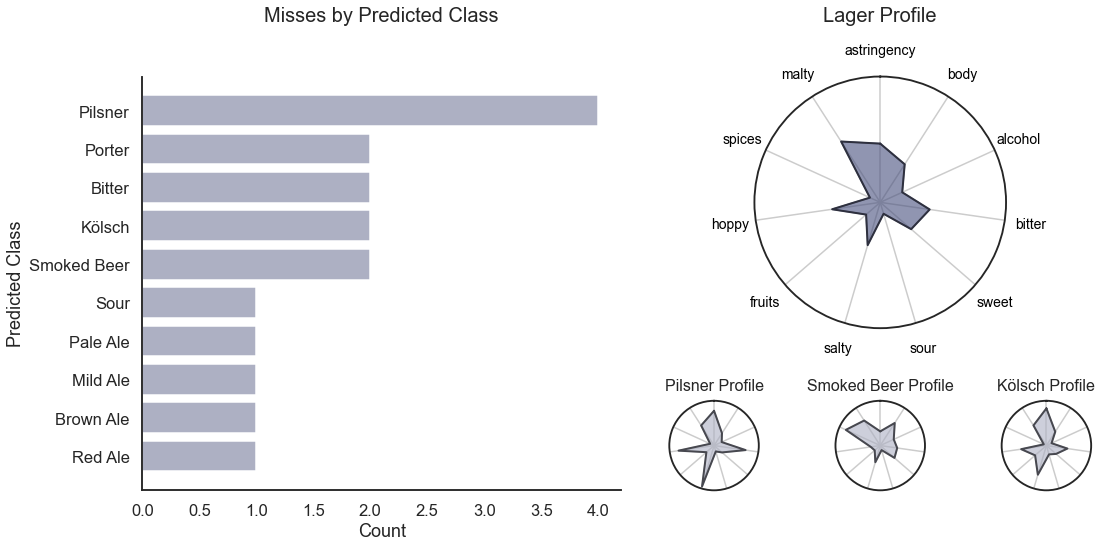

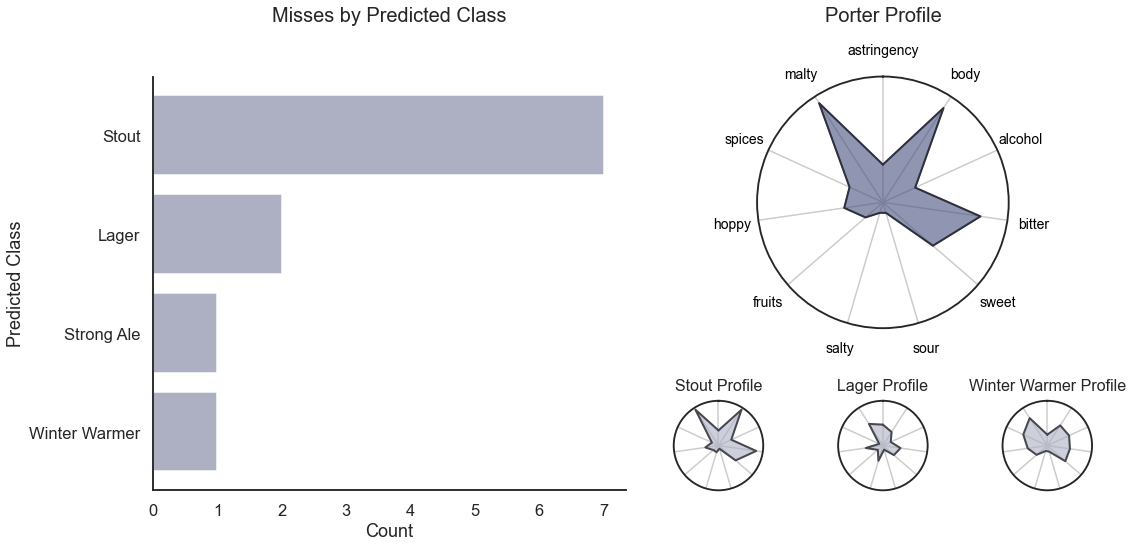

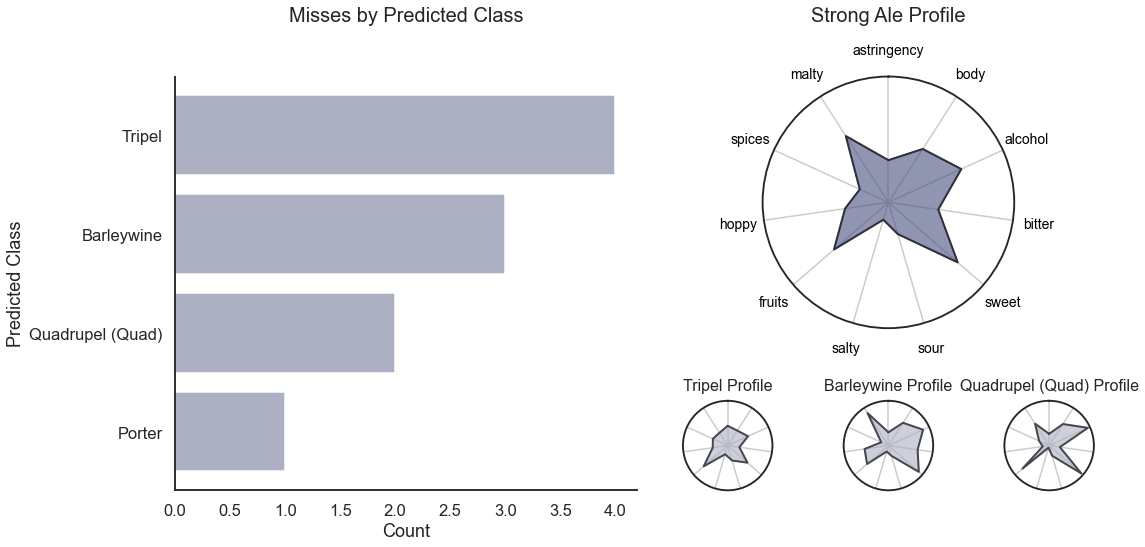

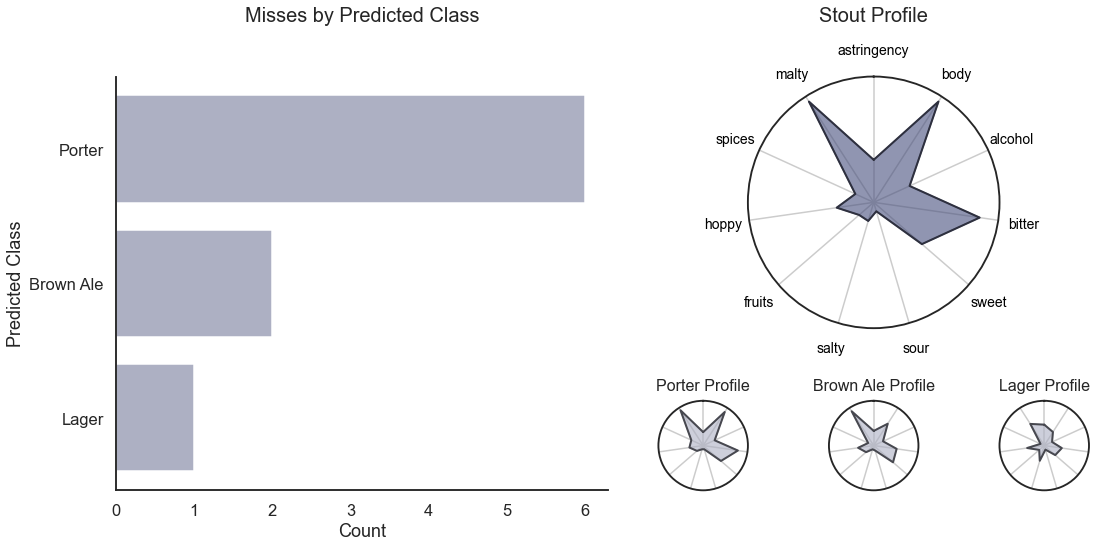

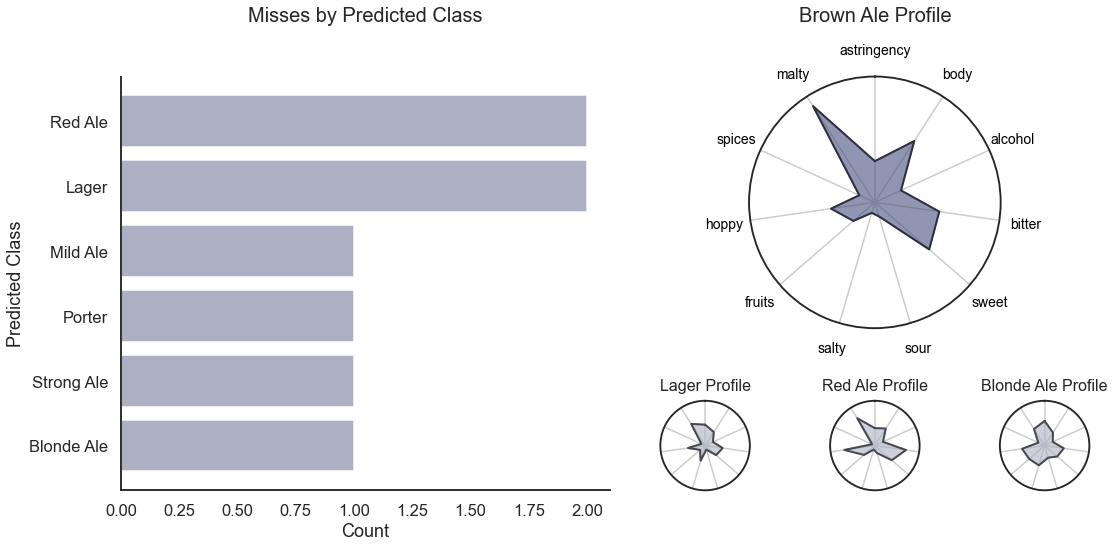

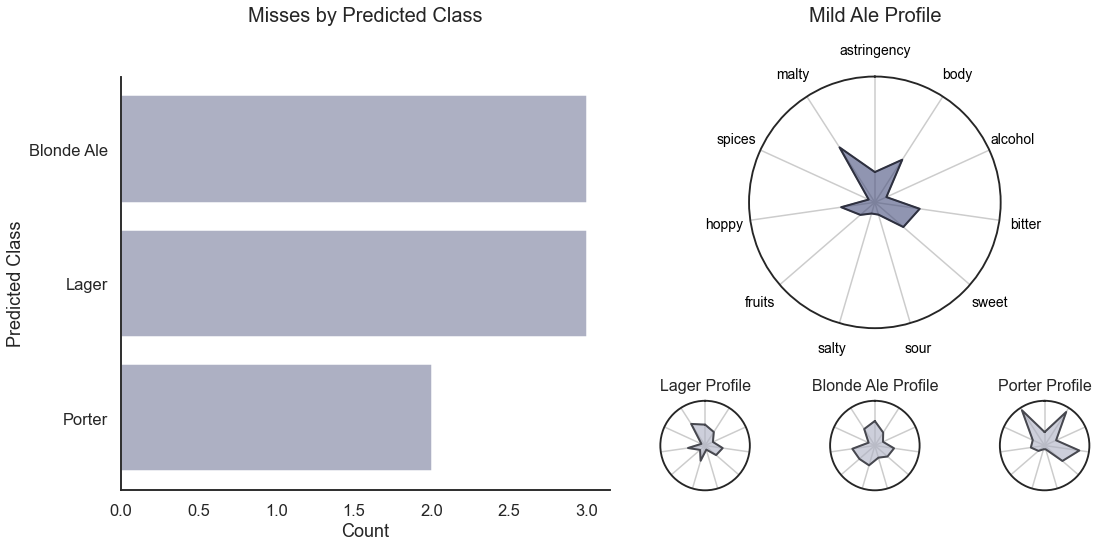

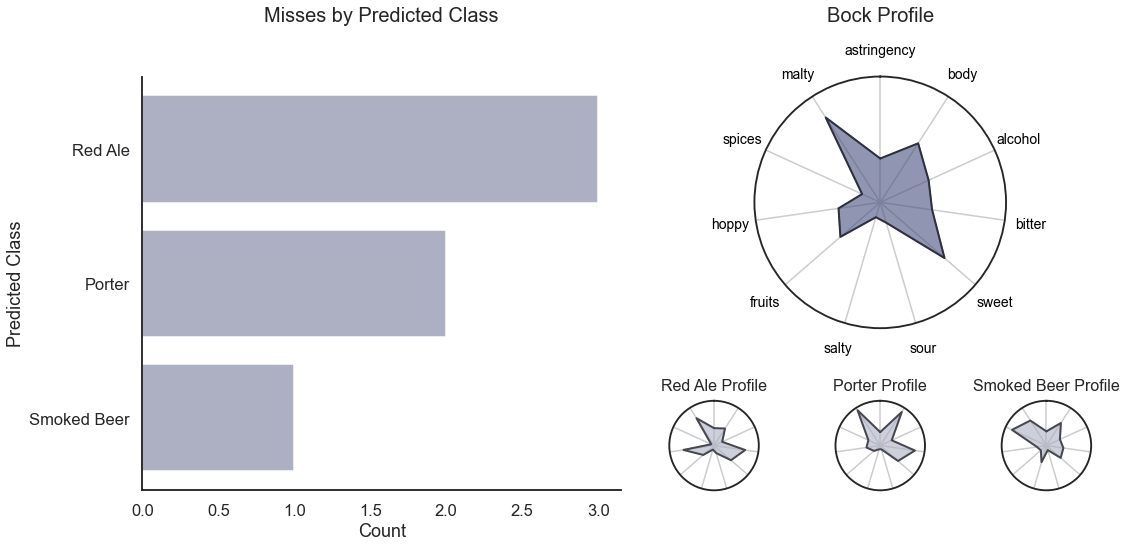

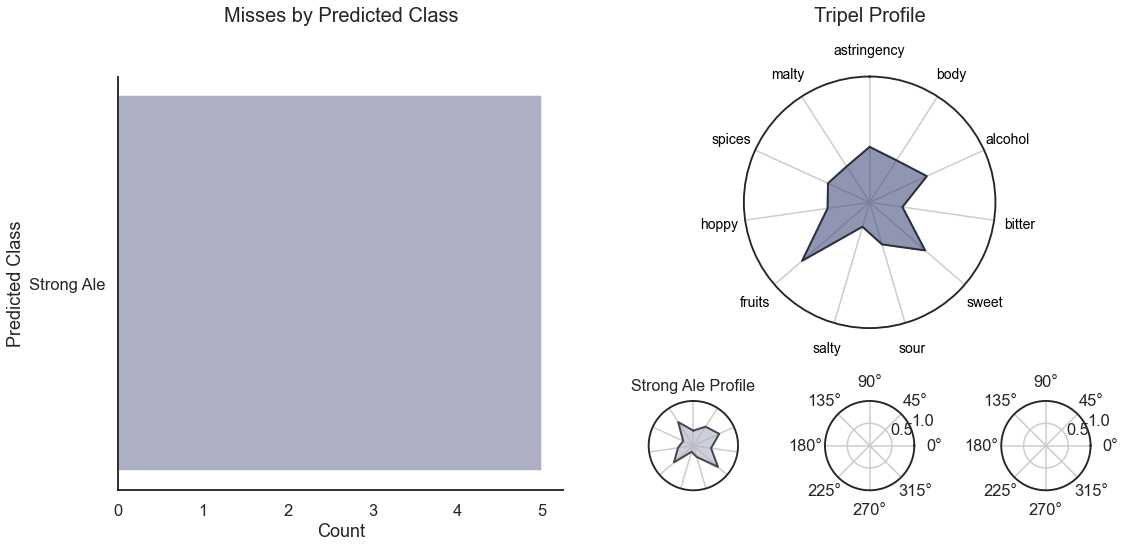

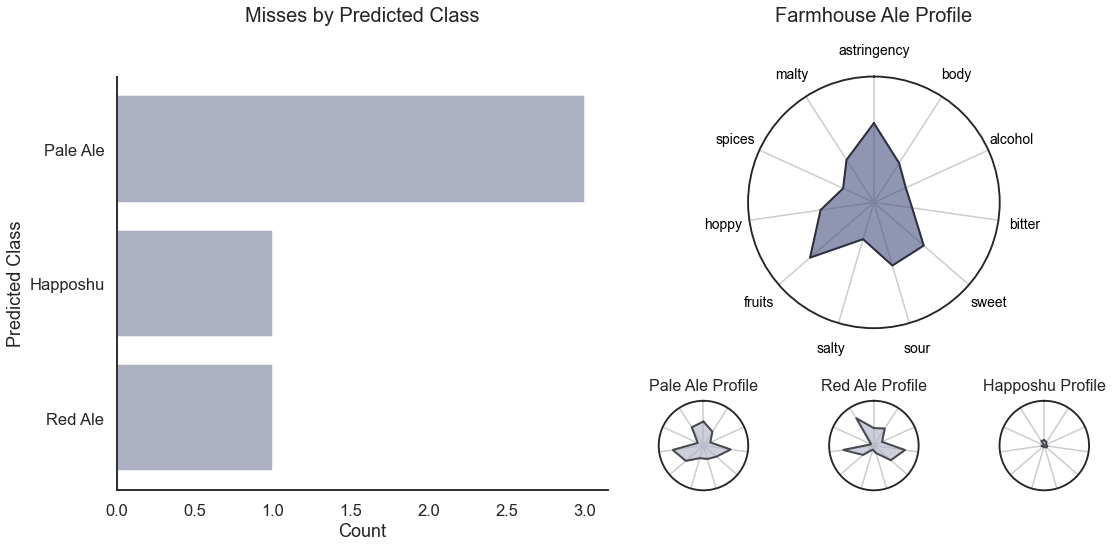

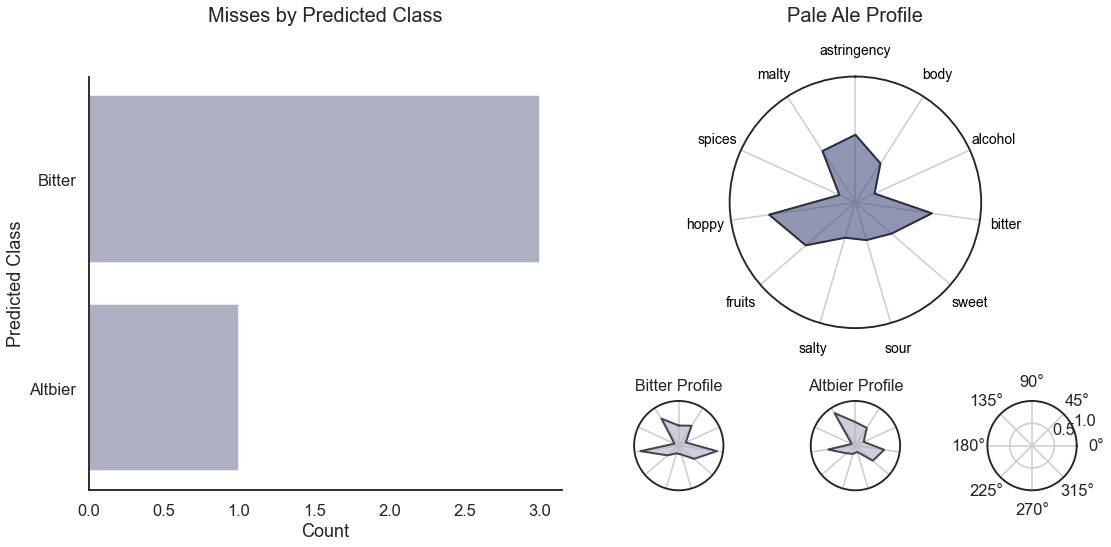

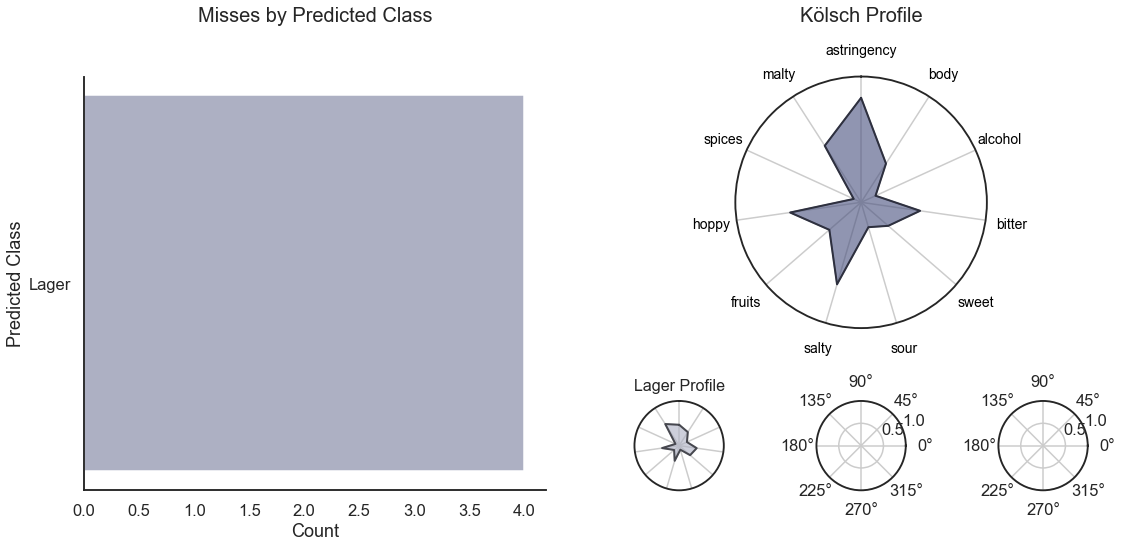

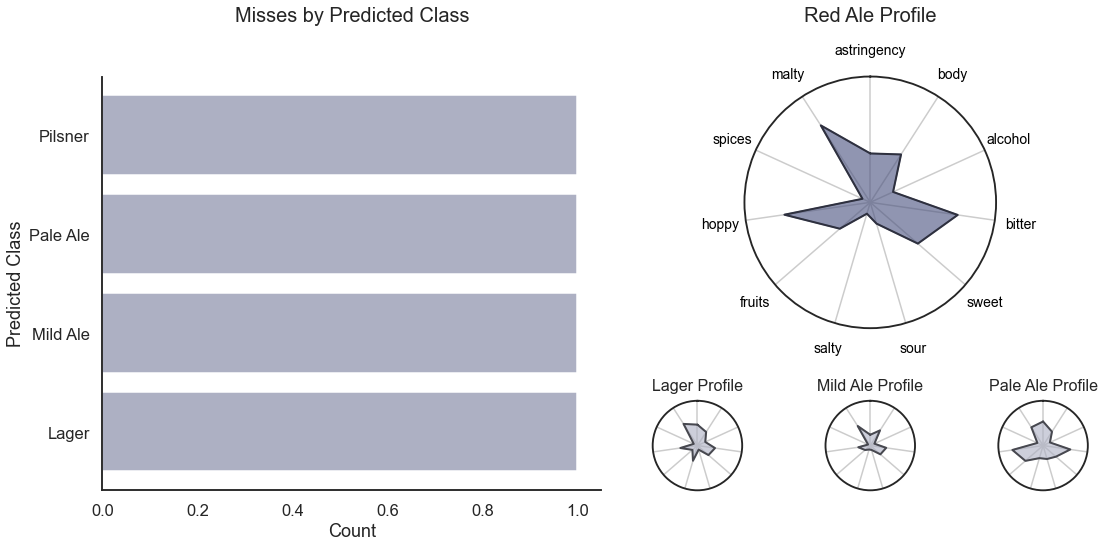

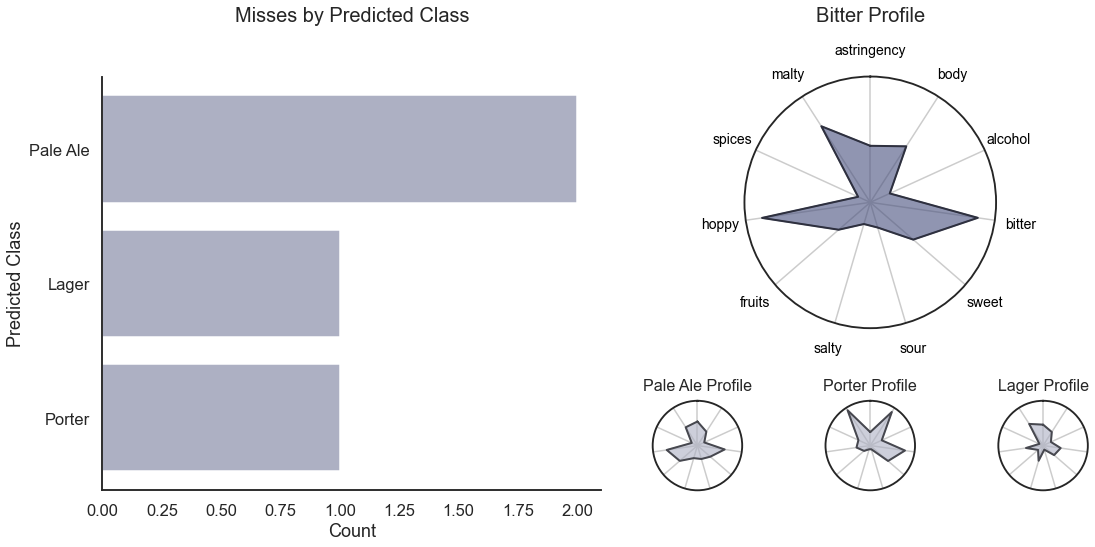

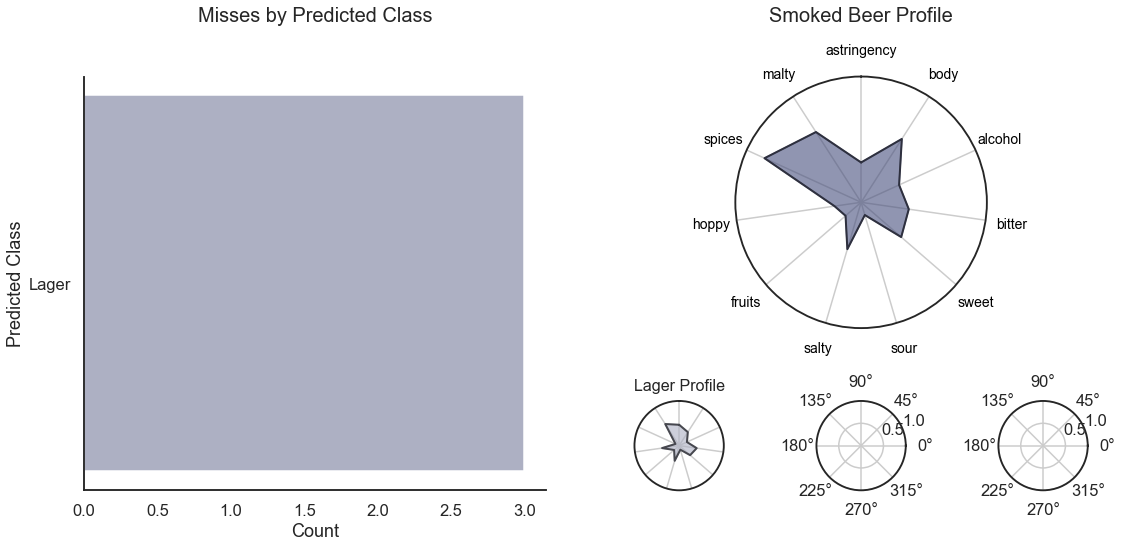

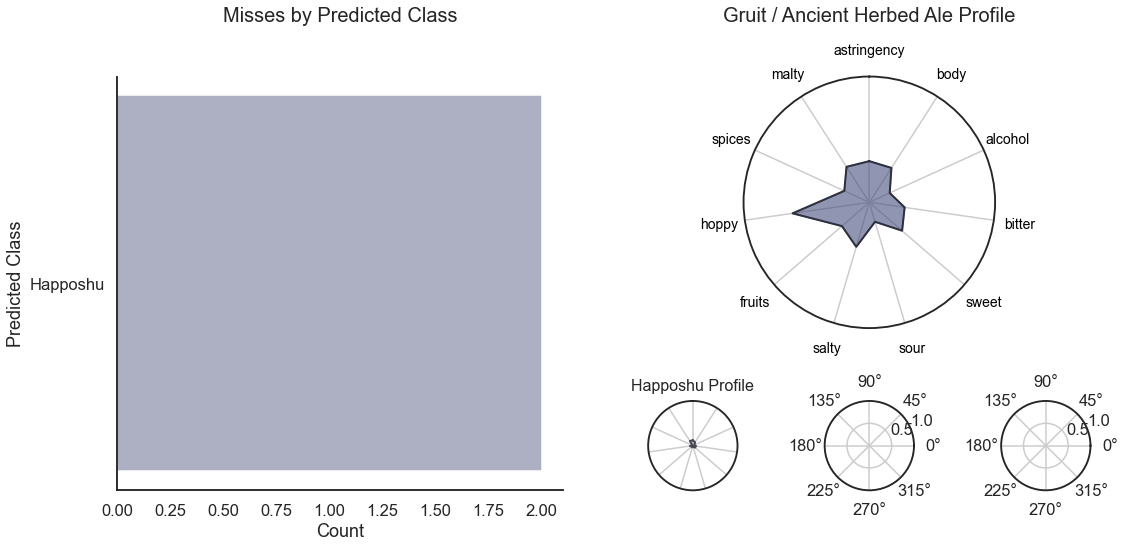

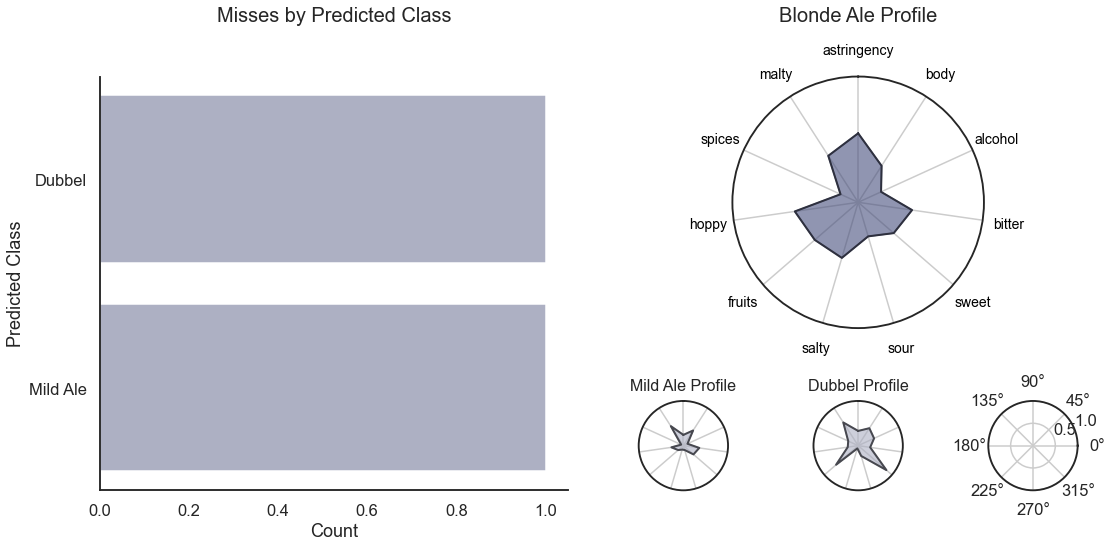

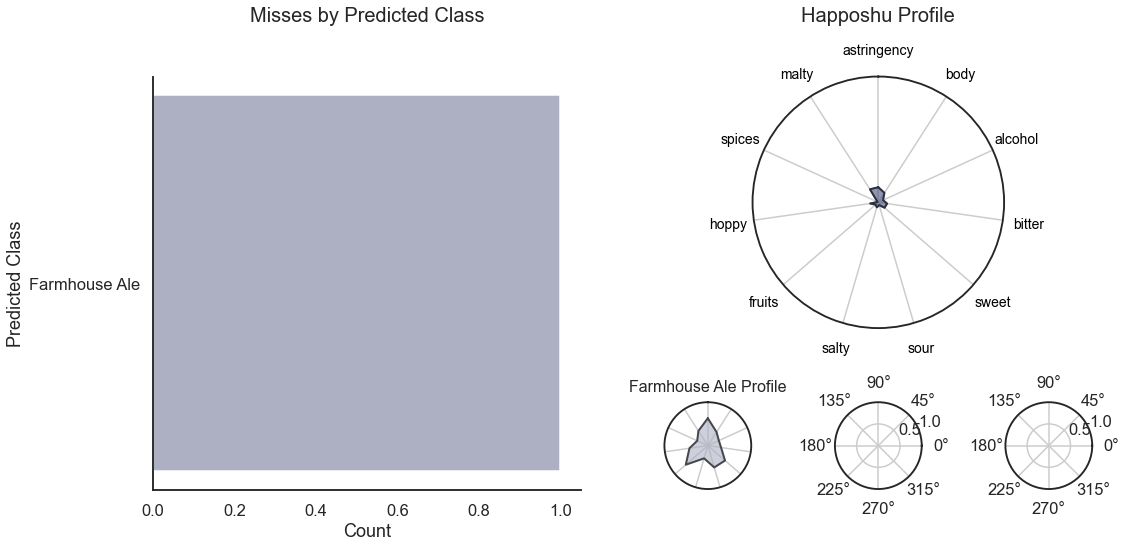

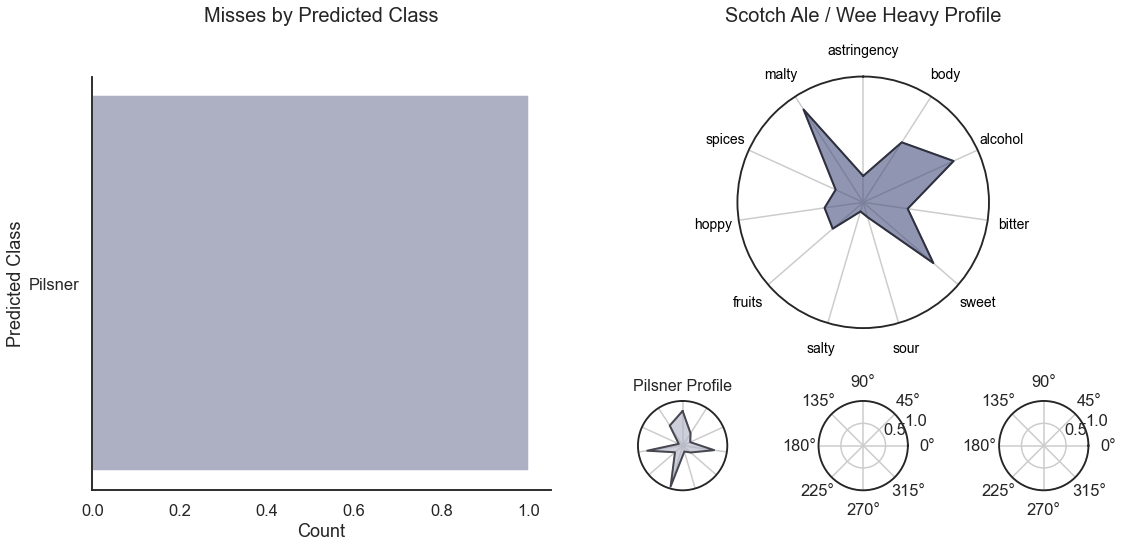

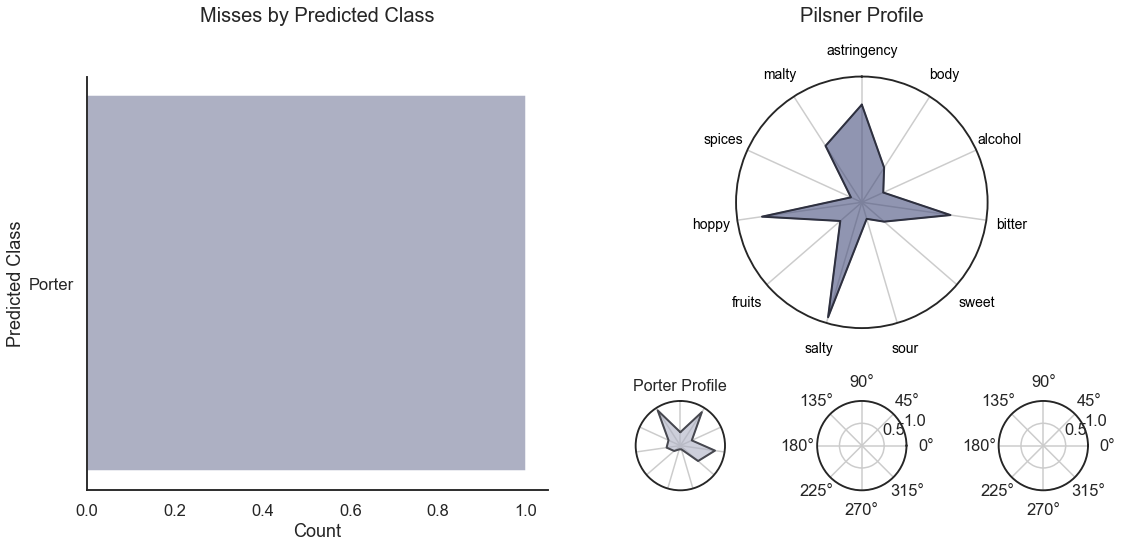

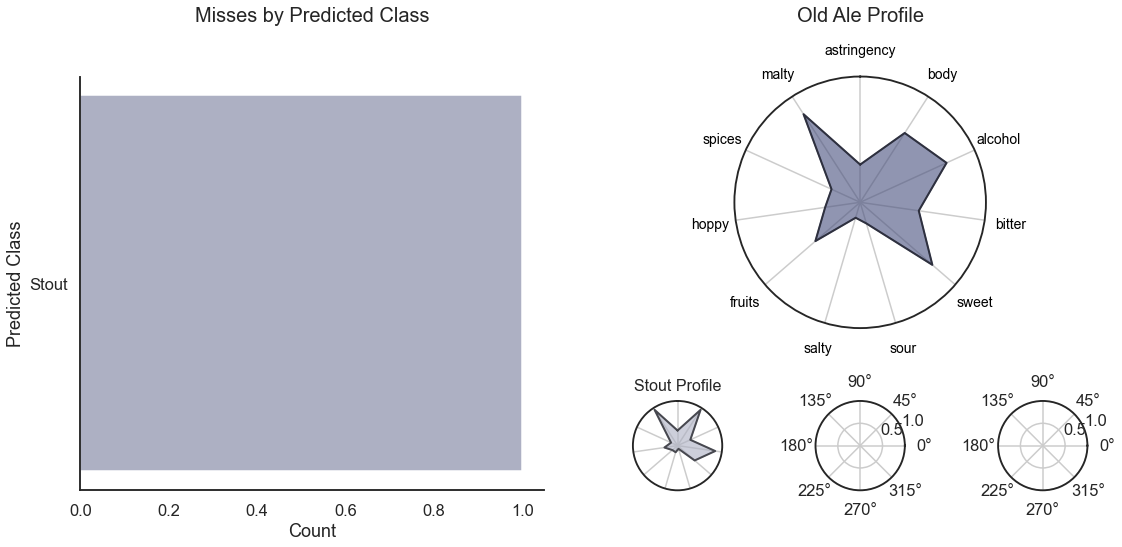

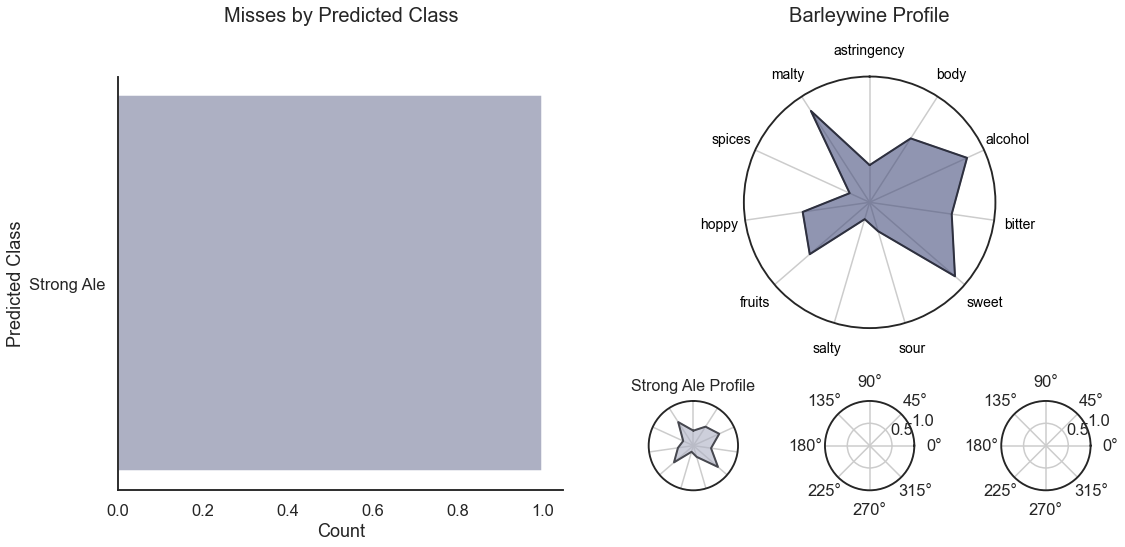

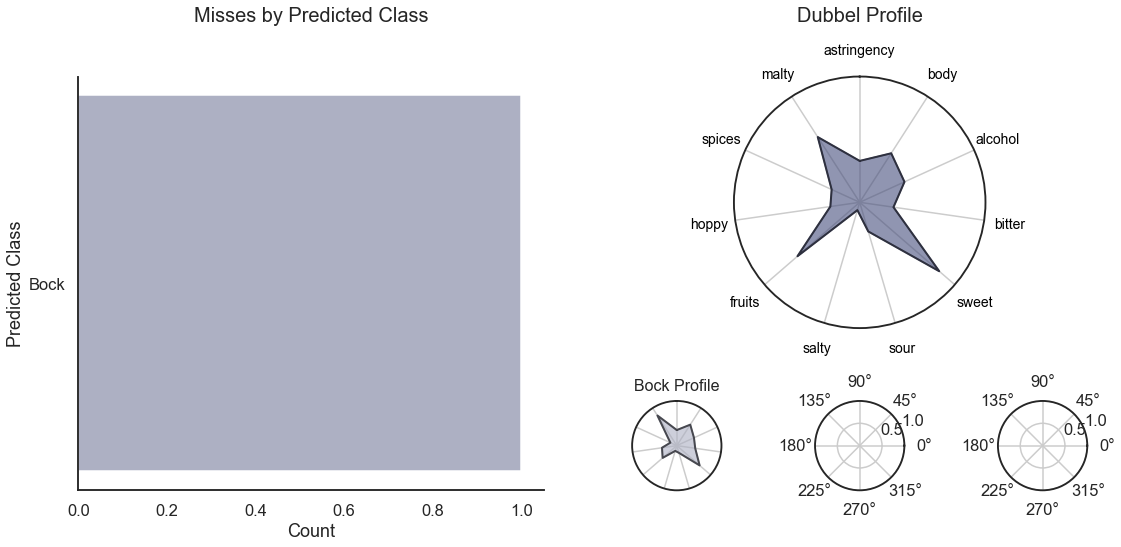

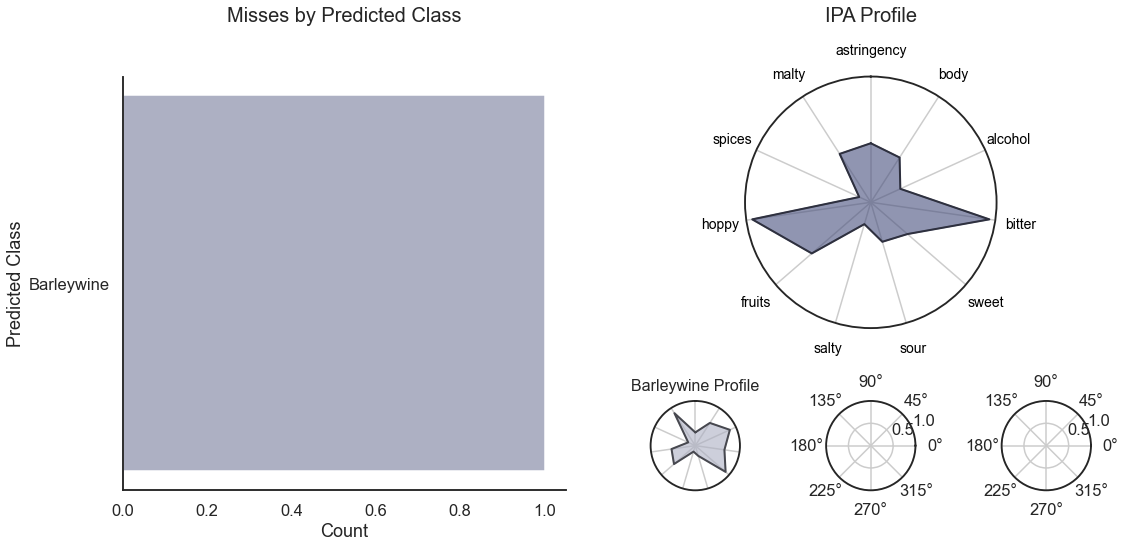

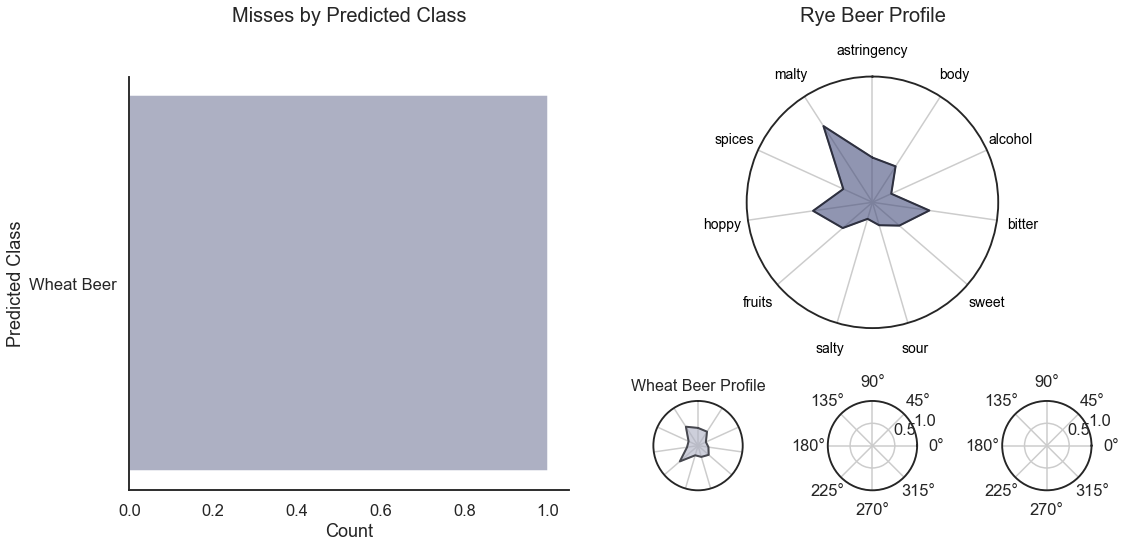

In [137]:
for ind, row in miss_summ_df.iterrows():
    style = row['actuals']
    n_actuals = row['predictions']
    n_misses = row['misses']

    if n_misses > 0:

        df_agg_row = df_agg.query(f'style_l1=="{style}"').index.values[0]

        temp_detail_df = miss_detail_df.query(f'actuals=="{style}"').sort_values('match')

        fig=plt.figure(figsize=(16, 8))

        gs=GridSpec(3, 6)

        ax_main=fig.add_subplot(gs[0:2, 3:6], projection='polar')
        ax_bar=fig.add_subplot(gs[:, 0:3])
        ax1=fig.add_subplot(gs[2, 3], projection='polar')
        ax2=fig.add_subplot(gs[2, 4], projection='polar')
        ax3=fig.add_subplot(gs[2, 5], projection='polar')

        make_spider(df_agg, df_agg_row, ax_main, color=main_color, title=f"{style} Profile")

        color_cmap = sns.light_palette(main_color, as_cmap=True)
        light_color = color_cmap(0.4) 

        ax_bar.barh('predictions', 'match', data=temp_detail_df, align='center', color=light_color)
        # bp = sns.barplot(data=temp_detail_df, y='predictions', x='match', ax=ax_bar, color=light_color)
        ax_bar.spines['top'].set_visible(False)
        ax_bar.spines['right'].set_visible(False)
        ax_bar.set_xlabel('Count')
        ax_bar.set_ylabel('Predicted Class')
        ax_bar.set_title('Misses by Predicted Class', pad=55, fontsize=20)

        for ax, (_, row_det) in zip([ax1, ax2, ax3], temp_detail_df.sort_values('match', ascending=False).head(3).iterrows()):
            style_det = row_det['predictions']
            n_misses_det = row_det['match']
            df_agg_row_det = df_agg.query(f'style_l1=="{style_det}"').index.values[0]
            make_spider(df_agg, df_agg_row_det, ax, color=light_color, title=f"{style_det} Profile", main=False)

        gs.tight_layout(fig, pad=1.1)

        plt.savefig(f'figures/miss_summary_{str.replace(str.replace(str.lower(style), " ", "_"), "/", "")}.png', transparent=True)